In [2]:
%load_ext autoreload
%autoreload 2

import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling.physical_models import BlackBody
import astropy.units as u
import astropy.constants as const


environments = [NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43),
                NLTE.NLTE_model.Environment(T_phot= 2750, photosphere_velocity= 0.190, line_velocity= 0.190, t_d=3.41)]

[<NLTE.NLTE_model.CollisionProcess object at 0x7f395e60ad70>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f3963beb190>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f395e682050>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f395e681180>]


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


[<NLTE.NLTE_model.CollisionProcess object at 0x7f395eba53f0>, <NLTE.NLTE_model.RadiativeProcess object at 0x7f39c82a1810>, <NLTE.NLTE_model.RecombinationProcess object at 0x7f395e682410>, <NLTE.NLTE_model.HotElectronIonizationProcess object at 0x7f39c82a2e90>]


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

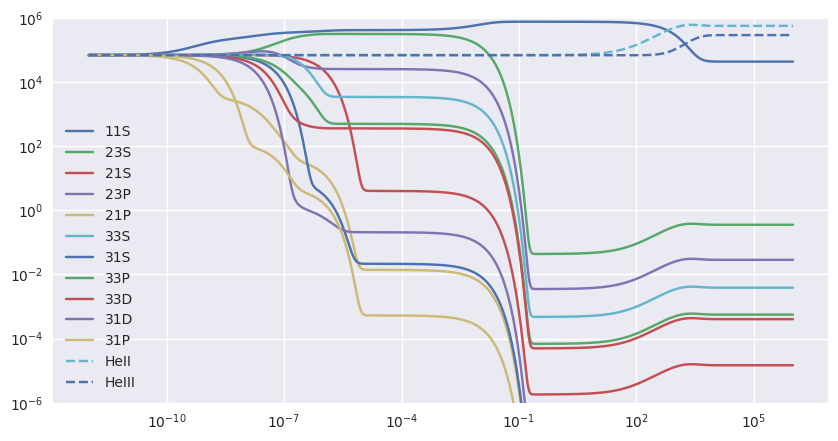

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

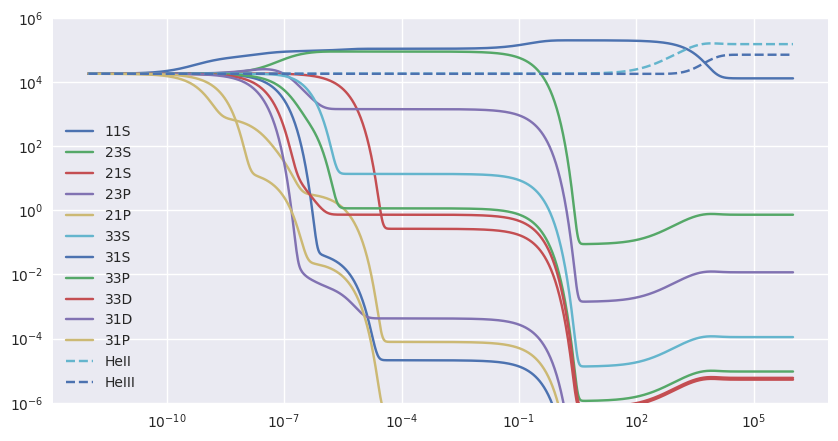

In [3]:
states = NLTE.NLTE_model.States()
for environment in environments:
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
    nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
    print(nlte_solver.processes)
    t, y = nlte_solver.solve(np.geomspace(1e-12,1000000, 1000))
    plt.figure(figsize=(10,5))
    plt.plot(t, y.T[:, :-2], label = states.names);
    plt.plot(t, y.T[:, -2:], linestyle="--", label  = ["HeII", "HeIII"]);
    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-6, 1e6)
    plt.legend()
    #for name, amount in zip(states.names + ["HeII", "HeIII"], y.T[-1]):
    #    print(name, amount)

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

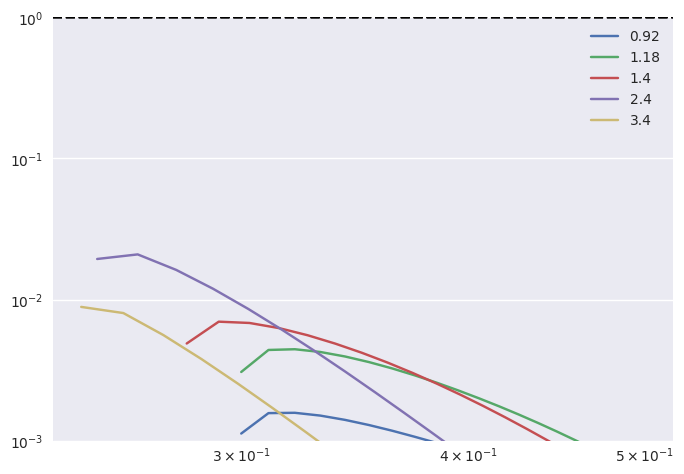

In [4]:

parameters = [{"T_phot": 5400, "photosphere_velocity": 0.3, "t_d": 0.92},
              {"T_phot": 4400, "photosphere_velocity": 0.3, "t_d": 1.18},
              {"T_phot": 4200, "photosphere_velocity": 0.28, "t_d": 1.4},
              {"T_phot": 3300, "photosphere_velocity": 0.25, "t_d": 2.4},
              {"T_phot": 3000, "photosphere_velocity": 0.245, "t_d": 3.4},
              ]# TODO: rest
density_table = []
for params in parameters:
    velocities = np.linspace(params["photosphere_velocity"], 0.5, 20)
    densities = []
    for v in velocities:
        environment  = NLTE.NLTE_model.Environment(**params, line_velocity= v)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
        densities.append(nlte_solver.solve(1e7)[1][:, -1])
    density_table.append(np.array(densities))
    densities = np.array(densities)
    plt.plot(velocities, densities[:,1]/(7.4*params["t_d"]**-1), label = params["t_d"]);
    plt.yscale("log")
    plt.axhline(1, linestyle="--", color="black")
    plt.xscale("log")
    plt.ylim(1e-3, 1e0)
    plt.legend()
    #for name, amount in zip(states.names + ["HeII", "HeIII"], y.T[-1]):
    #    print(name, amount)

In [5]:
import pickle
density_table = np.array(density_table)
pickle.dump({"densities":density_table, "parameters" : parameters, "states" : nlte_solver.states}, open("densities.pkl", "wb"))


In [6]:
import astropy.units as u
(4 * u.u).cgs

<Quantity 6.64215627e-24 g>

In [7]:

# demonstrate how to open the pickle file
import pickle
data = pickle.load(open("densities.pkl", "rb"))
data["densities"] # shape: (times, velocities, species)
data["parameters"] # dictionary of parameters  
data["states"] # list of species names
velocities = np.linspace(data["parameters"][0]["photosphere_velocity"], 0.5, 20)

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

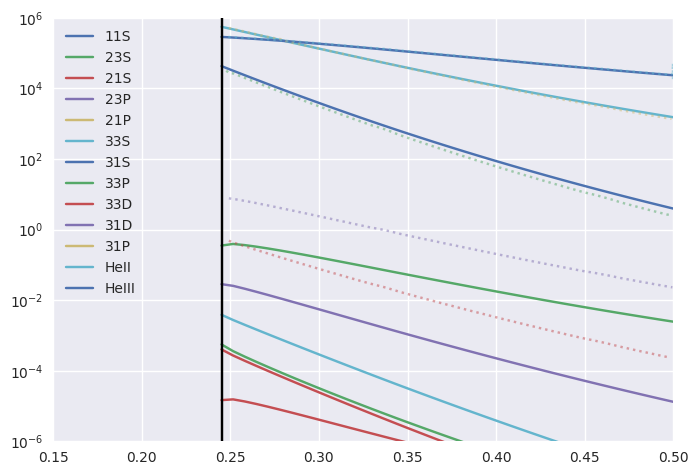

In [8]:
states = NLTE.NLTE_model.States()
velocities = np.linspace(0.245, 0.5, 40)
densities = []
for v in velocities:
    environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= v, t_d=1.43)
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
    nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
    densities.append(nlte_solver.solve(1e7)[1][:, -1])

    
for name, amount in zip(states.all_names, np.array(densities).T):
    plt.plot(velocities, amount, label=name)
plt.yscale("log")
plt.legend()
plt.ylim(1e-6, 1e6)


tarumi_states = ["11S", "23P", "23S", "He+", "He2+"]
for name in tarumi_states:
    velocity_23S, pops_23S = np.loadtxt(f"Tarumi_densities/Early{name}.csv", unpack=True, delimiter=";")
    plt.plot(velocity_23S, pops_23S, label=name, alpha=0.5, linestyle=":")
plt.xlim(0.15, 0.5)
plt.axvline(0.245, linestyle="-", color="black")

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

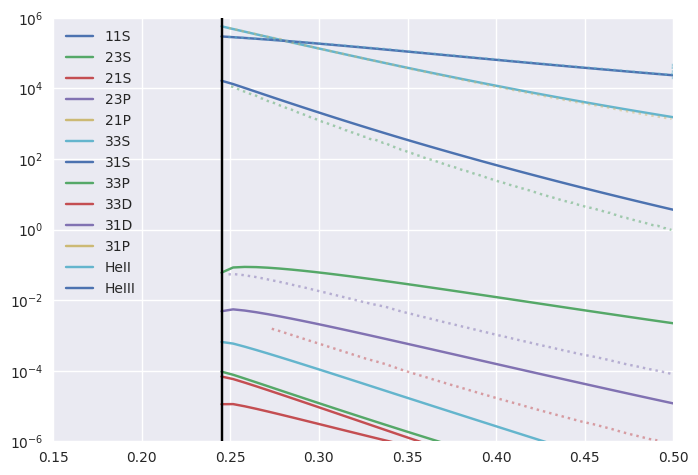

In [9]:
states = NLTE.NLTE_model.States()
velocities = np.linspace(0.245, 0.5, 40)
densities = []
for v in velocities:
    environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= v, t_d=1.43)
    #environment.spectrum = BlackBody(environment.spectrum.temperature, scale=0.*environment.spectrum.scale)
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
    #nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
    densities.append(nlte_solver.solve(1e7)[1][:, -1])

    
for name, amount in zip(states.all_names, np.array(densities).T):
    plt.plot(velocities, amount, label=name)
plt.yscale("log")
plt.legend()
plt.ylim(1e-6, 1e6)


tarumi_states = ["11Swithout", "23Pwithout", "23Swithout", "He+", "He2+"]
for name in tarumi_states:
    velocity_23S, pops_23S = np.loadtxt(f"Tarumi_densities/Early{name}.csv", unpack=True, delimiter=";")
    plt.plot(velocity_23S, pops_23S, label=name, alpha=0.5, linestyle=":")
plt.xlim(0.15, 0.5)
plt.axvline(0.245, linestyle="-", color="black")

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

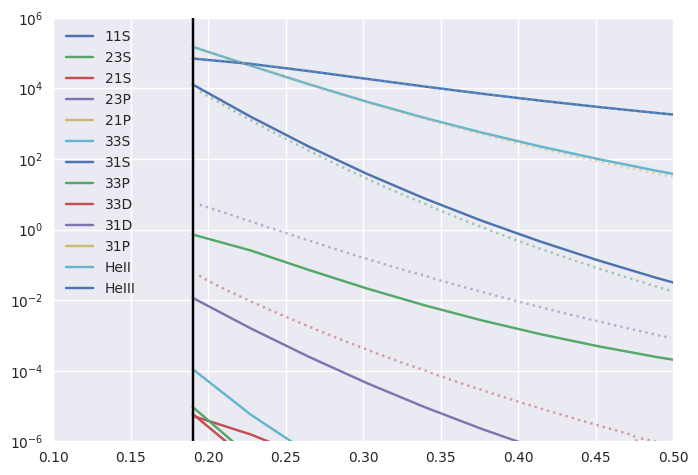

In [10]:
states = NLTE.NLTE_model.States()
velocities = np.linspace(0.19, 0.9, 20)
densities = []
for v in velocities:
    #states = NLTE.NLTE_model.States().filter(["11S", "23S", "21S", "23P", "21P", "33S"])
    environment  = NLTE.NLTE_model.Environment(T_phot= 2750, photosphere_velocity= 0.19, line_velocity= v, t_d= 3.41)
    nlte_solver = NLTE.NLTE_model.NLTESolver(environment)#, states=states)
    nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
    densities.append(nlte_solver.solve(1e7)[1][:, -1])

for name, amount in zip(states.all_names, np.array(densities).T):
    plt.plot(velocities, amount, label=name)
plt.yscale("log")
plt.legend()
plt.ylim(1e-6, 1e6)

tarumi_states = ["11S", "23P", "23S", "He+", "He2+"]
for name in tarumi_states:
    velocity_23S, pops_23S = np.loadtxt(f"Tarumi_densities/late{name}.csv", unpack=True, delimiter=";")
    plt.plot(velocity_23S, pops_23S, label=name, alpha=0.5, linestyle=":")
plt.xlim(0.1, 0.5)
plt.axvline(0.19, linestyle="-", color="black")

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

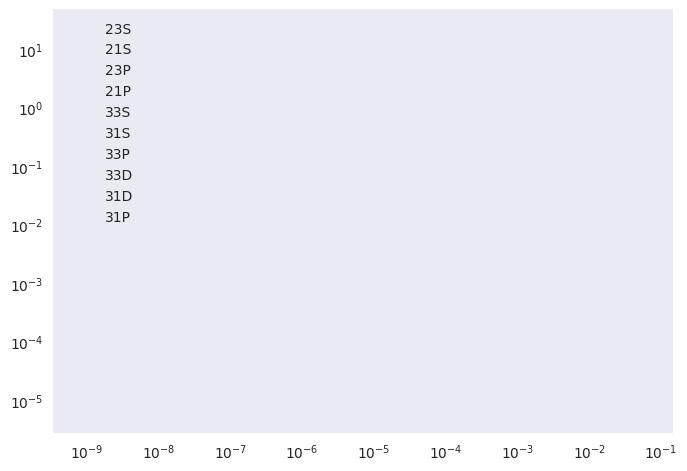

In [11]:
environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43)
#environment.spectrum = BlackBody(environment.spectrum.temperature, scale=0.*environment.spectrum.scale)
nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
nlte_solver.processes = nlte_solver.processes
density = nlte_solver.solve(1e7)[1][:, -1]

p_i = states.multiplicities * np.exp(-(states.energies - states.energies[1]) / (const.k_B * 4400*u.K))
p_i = p_i * density[1] / p_i[1]
for name, amount, expected in zip(states.all_names[1:], density[1:-2], p_i[1:]):
    plt.loglog(amount, amount/expected, "x", label=name)
plt.legend()
plt.grid()

In [12]:
densities[0][:-2]

array([1.28467910e+04, 7.21460932e-01, 5.22409323e-06, 1.15785458e-02,
       1.24400739e-09, 1.10668075e-04, 1.80937321e-10, 9.36023670e-06,
       5.93278927e-06, 3.46634616e-09, 8.36780426e-12])

In [24]:
import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator


import networkx as nx
import NLTE.NLTE_model
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('seaborn-v0_8')


# A_{i,j} = rate to state i from state j 
#environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity=  0.245, t_d=1.43)
for environment in environments:
        #plt.figure(figsize=(8,6))
        # make subplots with the second one being taller
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [0.5, 2.5, 0.5]})
        plt.subplots_adjust(wspace=0, hspace=0)
        nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
        nlte_solver.processes = nlte_solver.processes
        t, y = nlte_solver.solve(1e6)
        max_flux = np.max(nlte_solver.get_transition_rate_matrix() * y.T[-1][None,:])
        for i, process in enumerate(nlte_solver.processes):
                process_fluxes = (process.get_transition_rate_matrix() * y.T[-1][None,:]).T

                # give nodes the names states.names + ["HeII", "HeIII"]
                order= [0,2,4,6,9, 10,1, 3, 5, 7, 8, 11, 12]
                #order = np.arange(len(states.names) + 2)
                widths = np.clip(np.log10(process_fluxes/max_flux)+6, 0, 10)*0.4
                G = nx.DiGraph(widths[order, :][:, order])
                # rename nodes:
                labels = {i:name for i, name in enumerate(np.array(nlte_solver.states.all_names)[order])}
                G = nx.relabel_nodes(G, labels)
                weights = nx.get_edge_attributes(G,'weight').values()
                pos = {"11S": (0,-3), "21S": (0, 1), "31S": (0, 2),
                                      "21P": (1, 0), "31P": (1, 1), 
                                                     "31D": (2, 0), 
                                      "23S": (3, 1), "33S": (3, 2),
                                      "23P": (4, 0), "33P": (4, 1), 
                                                     "33D": (5, 0), 
                       }
                final_pos = {name: (pos[name][0], energy.value) for name, energy in zip(nlte_solver.states.all_names, nlte_solver.states.energies)} 
                final_pos["HeII"] = (2.5, 24.5)
                final_pos["HeIII"] = (1.5, 24.5)
                final_pos["11S"] = 0, 18.5
                labels = {name: f"${name[0]}^{name[1]}{name[2]}$" for name in nlte_solver.states.all_names}
                labels["HeII"] = "$He^+$"
                labels["HeIII"] = "$He^{2+}$"
                #pos = nx.circular_layout(G)
                for ax in [ax1, ax2, ax3]:
                        nx.draw(G, final_pos, ax=ax,
                                width=list(weights),
                                edge_color=f'C{i}' ,connectionstyle="arc3,rad=0.1",
                                with_labels=True, labels=labels, 
                                node_color='lightblue', node_size=700, font_size=10, font_weight="light",)
                plt.plot([],[], color=f'C{i}', label=f'{process.name}')
        ax3.set_ylim(18, 19)
        ax2.set_ylim(19, 24)
        ax2.axhline(24, linestyle="-", linewidth=10, alpha=0.2, color="black")
        ax2.axvline(3.5, linestyle="-", linewidth=2, alpha=0.2, color="black")
        ax3.axvline(3.5, linestyle="-", linewidth=2, alpha=0.2, color="black")
        ax1.set_ylim(24, 25)
        
        ax1.spines.bottom.set_visible(False)
        ax2.spines.top.set_visible(False)
        ax2.spines.bottom.set_visible(False)
        ax3.spines.top.set_visible(False)

        ax1.axis("on")
        ax2.axis("on")
        ax3.axis("on")
        ax2.tick_params(left=True, labelleft=True)
        ax3.tick_params(left=True, labelleft=True, labelbottom=True, bottom=True, which="both")
        
        d = .5  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax2.plot([0], [0.02], transform=ax2.transAxes, **kwargs)
        ax3.plot([0], [0.98], transform=ax3.transAxes, **kwargs)
        ax1.plot([0], [0.02], transform=ax1.transAxes, **kwargs)
        ax2.plot([0], [0.98], transform=ax2.transAxes, **kwargs)
        ax2.set_ylabel("Energy [eV]")
        ax3.set_xlabel("State")
        ax3.set_yticks([final_pos["11S"][1]])
        ax3.set_yticklabels(["0"])
        ax2.set_yticks(ax2.get_yticks()[1:-1])
        plt.legend(loc="lower right", title="Process types")
        ax3.tick_params(axis='x', which='major', pad=20)
        ax3.set_xticks([1.001, 3.999])
        ax3.set_xticklabels(["Para", "Ortho"])
        ax3.minorticks_on()
        ax3.set_xticks([0, 1, 2, 3, 4, 5], minor=True)

        ax3.set_xticklabels(["S", "P", "D", "S", "P", "D"], minor=True)
        #plt.setp(ax.get_xticklabels(), rotation=0)

        ax1.grid()
        ax2.grid()
        ax3.grid()
        if environment.t_d < 3:
                plt.suptitle("Early phase transition rates")

        else:
                plt.suptitle("Late phase transition rates")
        plt.savefig(f"transition_rates_{environment.t_d}.pdf", bbox_inches="tight")
        plt.savefig(f"transition_rates_{environment.t_d}.png", bbox_inches="tight", dpi=300)

/tmp/ipykernel_826/2891702270.py:33: RuntimeWarning: divide by zero encountered in log10
  widths = np.clip(np.log10(process_fluxes/max_flux)+6, 0, 10)*0.4


In [14]:
ax.xaxis.get_ticklocs(minor=True)     # []


array([0, 1, 2, 3, 4, 5])

In [301]:
labels = {name: f"${name[0]}*{name[1]}{name[2]}" for name in nlte_solver.states.all_names}


for process Collision the max flux into ortho states is 0.0033134052192236195, which is from state 21S to state 23S
for process Radiative the max flux into ortho states is 0.0005020903158711679, which is from state 31D to state 23P
for process Photoionization the max flux into ortho states is 0.0, which is from state 11S to state 23S
for process Recombination the max flux into ortho states is 34.52318075042101, which is from state HeII to state 23S
for process Hot electron ionization the max flux into ortho states is 0.0, which is from state 11S to state 23S


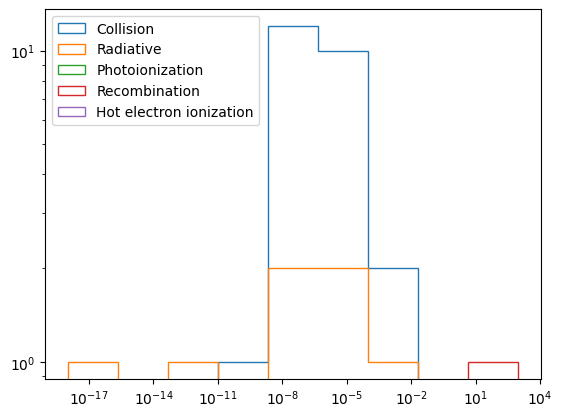

for process Collision the max flux out of ortho states is 0.722767508585616, which is from state 23S to state 21S
for process Radiative the max flux out of ortho states is 2.5895846891066947, which is from state 23P to state 31D
for process Photoionization the max flux out of ortho states is 11.20386792490977, which is from state 33S to state HeII
for process Recombination the max flux out of ortho states is 0.0, which is from state 23S to state 11S
for process Hot electron ionization the max flux out of ortho states is 6.282525732494564e-05, which is from state 23S to state HeII


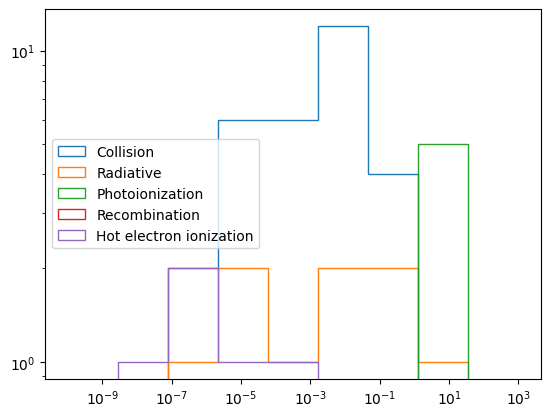

In [233]:
# make histogram of the flux sizes for each process
environment  = NLTE.NLTE_model.Environment(T_phot= 4400, photosphere_velocity= 0.245, line_velocity= 0.245, t_d=1.43)
nlte_solver = NLTE.NLTE_model.NLTESolver(environment)
#nlte_solver.processes = nlte_solver.processes[:2] + nlte_solver.processes[3:]
t, y = nlte_solver.solve(1000000)

ortho_states = np.array([name[1] == "3" for name in nlte_solver.states.all_names])
for process in nlte_solver.processes:
    fluxes =  process.get_transition_rate_matrix()* y.T[-1][None,:] 
    in_fluxes = fluxes[ortho_states, :][:, ~ortho_states]
    idx = np.unravel_index(np.argmax(in_fluxes), in_fluxes.shape)
    plt.hist(in_fluxes.flatten(), bins=np.geomspace(1e-18, 1000, 10), label=process.name, alpha=1, histtype="step")
    print(f"for process {process.name} the max flux into ortho states is {np.max(in_fluxes)}, which is from state {np.array(nlte_solver.states.all_names)[~ortho_states][idx[1]]} to state {np.array(nlte_solver.states.all_names)[ortho_states][idx[0]]}")

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()
for process in nlte_solver.processes:
    fluxes =  process.get_transition_rate_matrix()* y.T[-1][None,:] 
    out_fluxes = fluxes[~ortho_states, :][:, ortho_states]
    idx = np.unravel_index(np.argmax(out_fluxes), out_fluxes.shape)
    plt.hist(out_fluxes.flatten(), bins=np.geomspace(1e-10, 1000, 10), label=process.name, alpha=1, histtype="step")
    print(f"for process {process.name} the max flux out of ortho states is {np.max(out_fluxes)}, which is from state {np.array(nlte_solver.states.all_names)[ortho_states][idx[1]]} to state {np.array(nlte_solver.states.all_names)[~ortho_states][idx[0]]}")
plt.legend()
plt.xscale("log")
plt.yscale("log")

In [234]:
nlte_solver.processes[1].get_A_rates()[nlte_solver.states.all_names.index("11S"), nlte_solver.states.all_names.index("23P")]
nlte_solver.processes[1].get_A_rates()[nlte_solver.states.all_names.index("23P"), nlte_solver.states.all_names.index("33D")]
nlte_solver.processes[1].get_A_rates()[nlte_solver.states.all_names.index("21P"), nlte_solver.states.all_names.index("33P")]

0.0

nlte_solver.processes[1].get_A_rates()[nlte_solver.states.all_names.index("21S"), nlte_solver.states.all_names.index("23P")]

In [81]:
nlte_solver.processes[1].get_A_rates()[nlte_solver.states.all_names.index("11S"), nlte_solver.states.all_names.index("23P")]


176.4

In [82]:
import pandas
def get_A_rates(self):
    get_n = lambda n, l, count: (int(n)-1)*2 if count else (int(n)-1)
    nist_table = pandas.read_csv("atomic data/A_rates_NIST.csv")
    def get_state_name(config_series, term_series):
        n = config_series.str.findall("([\d+]+)([spdf])(2?)").apply(lambda x: str(1+sum([get_n(*nlm) for nlm in x])))
        term = term_series.str.strip("=\"*")
        return n+term

    lower_state = get_state_name(nist_table["conf_i"], nist_table["term_i"])
    upper_state = get_state_name(nist_table["conf_k"], nist_table["term_k"])

    A_coefficients = np.zeros((len(self.states.names), len(self.states.names)))

    for state_name in self.states.names:
        selection = (i_state == state_i) & (j_state.isin(names)) & (nist_table["Aki(s^-1)"] != '=""')
        selected_A = nist_table[selection]["Aki(s^-1)"].str.strip("=\"*")
        for state_j, A in zip(j_state[selection], selected_A):
            A_coefficients[self.states.names.index(state_i),self.states.names.index(state_j)] = float(A)
    
    A_coefficients[names.index("11S"), names.index("23P")] = 1.764e+02# 1.764e+02 	#3.27e-1
    """
    A_coefficients[names.index("11S"), names.index("23P")] = 0# 1.764e+02 	#3.27e-1
    A_coefficients[names.index("23P"), names.index("31D")] = 0# 1.764e+02 	#3.27e-1
    A_coefficients[names.index("21P"), names.index("33D")] = 0# 1.764e+02 	#3.27e-1
    A_coefficients[names.index("21P"), names.index("23S")] = 0# 1.764e+02 	#3.27e-1
    A_coefficients[names.index("31D"), names.index("33P")] = 0# 1.764e+02 	#3.27e-1
    """
    """
    # F. Drake 1969
    drake_coeff = {"11S": {"21S": 5.13e1}}#, "23S": 4.02e-9}}
    for state_i, subtable in drake_coeff.items():
        if state_i not in states:
            continue
        for state_j, coeff in subtable.items():
            if state_j not in states:
                continue
            A_coefficients[states.index(state_i),states.index(state_j)] = coeff
    """
    return A_coefficients

A_coefficients = get_A_rates(nlte_solver.processes[1])

NameError: name 'i_state' is not defined

In [249]:

get_n = lambda n, l, count: (int(n)-1)*2 if count else (int(n)-1)
nist_table = pandas.read_csv("atomic data/A_rates_NIST.csv")
def get_state_name(config_series, term_series):
    n = config_series.str.findall("([\d+]+)([spdf])(2?)").apply(lambda x: str(1+sum([get_n(*nlm) for nlm in x])))
    term = term_series.str.strip("=\"*")
    return n+term

lower_state = get_state_name(nist_table["conf_i"], nist_table["term_i"])
upper_state = get_state_name(nist_table["conf_k"], nist_table["term_k"])
A_coefficients = pandas.to_numeric(nist_table["Aki(s^-1)"].str.strip("=\"*"))
df = pandas.DataFrame({"lower_state": lower_state, "upper_state": upper_state, "A_coefficients": A_coefficients})
for (lower, upper), A in df.groupby(["lower_state", "upper_state"]):
    print(A)

     lower_state upper_state  A_coefficients
2299        101D        101P         0.85959
     lower_state upper_state  A_coefficients
2266        101S        101P          561.27
     lower_state upper_state  A_coefficients
2284        103P        103D          1.4739
2285        103P        103D         22.1090
2286        103P        103D         13.2640
2287        103P        103D         53.0610
2288        103P        103D         39.7930
2289        103P        103D         29.4780
     lower_state upper_state  A_coefficients
2252        103S        103P          1925.4
2253        103S        103P          1925.4
2254        103S        103P          1925.4
     lower_state upper_state  A_coefficients
744          11G        101F          830.39
1119         11G        101F         1658.60
1502         11G        101F         2384.20
1834         11G        101F         3093.70
2182         11G        101F         3894.70
     lower_state upper_state  A_coefficients
746       

In [251]:
nist_table.loc[1119]

obs_E(eV)                        =""
unc_obs_E                        =""
ritz_wn(eV)       ="0.2418468777467"
unc_ritz_wn       ="0.0000000000006"
intens                           =""
Aki(s^-1)              ="1.6586e+03"
Acc                              AAA
Ei(eV)         ="[24.2094923832773]"
Ek(eV)         ="[24.4513392610240]"
conf_i                      ="1s.6g"
term_i                         ="1G"
J_i                             ="4"
conf_k                     ="1s.10f"
term_k                        ="1F*"
J_k                             ="3"
g_i                                9
g_k                                7
Type                             NaN
tp_ref                   ="T8636c73"
line_ref                         =""
Unnamed: 20                      NaN
Name: 1119, dtype: object

In [ ]:
lower_state, upper_state, A_coefficients

(0        23P
 1        23P
 2        23P
 3        11S
 4        11S
         ... 
 2295     43D
 2296     43D
 2297     41D
 2298     91D
 2299    101D
 Length: 2300, dtype: object,
 0        33P
 1        33P
 2        33P
 3       151P
 4       141P
         ... 
 2295     43F
 2296     43F
 2297     41F
 2298     91P
 2299    101P
 Length: 2300, dtype: object,
 0            NaN
 1            NaN
 2            NaN
 3            NaN
 4            NaN
           ...   
 2295    0.050864
 2296    0.074329
 2297    0.022522
 2298    1.432500
 2299    0.859590
 Name: Aki(s^-1), Length: 2300, dtype: float64)

In [238]:
nist_table["g_k"]

0       9
1       9
2       9
3       3
4       3
       ..
2295    7
2296    5
2297    7
2298    3
2299    3
Name: g_k, Length: 2300, dtype: int64